# Feature Engineering

Objective: Create temporally valid features for predicting GW+1, GW+2, GW+3

Mathematical Foundation:
For prediction at time t, we construct feature vector X_t using only
information from {t-w, ..., t-1} where w is the lookback window.

Feature Categories:
1. Rolling Statistics (Mean, Std, Min, Max over windows)
2. Momentum Indicators (Trends, streaks, acceleration)
3. Lag Features (Historical points at specific lags)
4. Player Metadata (Position, form, fixtures)

Critical Constraint: NO INFORMATION LEAKAGE
X_t must be computable at gameweek t-1 (before match t starts)

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Paths
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"
DATA_FILE = PROCESSED_DIR / "fpl_unified_preprocessed.csv"

# Load data
df = pd.read_csv(DATA_FILE)

# Sort by temporal order (critical for feature engineering)
df = df.sort_values(['element', 'season', 'GW']).reset_index(drop=True)

print(f"Loaded: {len(df):,} observations")
print(f"Date range: {df['season'].min()} to {df['season'].max()}")

Loaded: 102,197 observations
Date range: 2021-22 to 2025-26


## 1. Rolling Statistics Features

### Mathematical formulation:


For player i at gameweek t with window size k:
$$\bar{X}_{i,t,k} = \frac{1}{k} \sum_{j=t-k}^{t-1} X_{i,j}$$
$$\sigma_{i,t,k} = \sqrt{\frac{1}{k} \sum_{j=t-k}^{t-1} (X_{i,j} - \bar{X}_{i,t,k})^2}$$

In [2]:
def create_rolling_features(df, windows=[3, 5, 10]):
    """
    Creates rolling statistics with temporal validity guarantee.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data sorted by [element, season, GW]
    windows : list
        Rolling window sizes (gameweeks)
        
    Returns
    -------
    pd.DataFrame
        DataFrame with rolling features
    """
    df = df.copy()
    
    # Target variable and key metrics
    rolling_cols = ['total_points', 'minutes', 'goals_scored', 'assists',
                    'clean_sheets', 'bonus', 'ict_index', 'bps']
    
    # Only use columns that exist
    rolling_cols = [col for col in rolling_cols if col in df.columns]
    
    print(f"Creating rolling features for: {rolling_cols}")
    print(f"Windows: {windows}")
    
    for col in rolling_cols:
        for window in windows:
            # Rolling Mean
            # shift(1) ensures we don't use current gameweek
            df[f'{col}_roll_mean_{window}'] = (
                df.groupby('element')[col]
                .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
            )
            
            # Rolling Std (volatility/consistency measure)
            df[f'{col}_roll_std_{window}'] = (
                df.groupby('element')[col]
                .transform(lambda x: x.shift(1).rolling(window, min_periods=1).std())
            )
            
            # Rolling Max (ceiling performance)
            df[f'{col}_roll_max_{window}'] = (
                df.groupby('element')[col]
                .transform(lambda x: x.shift(1).rolling(window, min_periods=1).max())
            )
    
    print(f"Created {len([c for c in df.columns if 'roll' in c])} rolling features")
    return df

In [5]:
df = create_rolling_features(df, windows=[3, 5, 10])

# Validate: Check that rolling features don't use future data
sample_player = df[df['element'] == df['element'].iloc[450]].head(15)
print("\nValidation Sample (First 15 GWs for random player):")
print(sample_player[['GW', 'total_points', 
                     'total_points_roll_mean_3', 
                     'total_points_roll_mean_5']].to_string())

Creating rolling features for: ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'ict_index', 'bps']
Windows: [3, 5, 10]
Created 72 rolling features

Validation Sample (First 15 GWs for random player):
     GW  total_points  total_points_roll_mean_3  total_points_roll_mean_5
428   1             0                       NaN                       NaN
429   2             1                  0.000000                  0.000000
430   3             1                  0.500000                  0.500000
431   4             9                  0.666667                  0.666667
432   5             2                  3.666667                  2.750000
433   6             7                  4.000000                  2.600000
434   7             2                  6.000000                  4.000000
435   8             9                  3.666667                  4.200000
436   9             6                  6.000000                  5.800000
437  10             2       

## 2. Momentum & Trend Features

Captures performance trajectory using discrete derivatives.

**First-order momentum** (velocity):
$$m_t^{(1)} = X_t - X_{t-1}$$

**Second-order momentum** (acceleration):
$$m_t^{(2)} = m_t^{(1)} - m_{t-1}^{(1)}$$

In [6]:
def create_momentum_features(df):
    """
    Creates momentum indicators capturing performance trends.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with momentum features
    """
    df = df.copy()
    
    # First-order: Point change (velocity)
    df['points_momentum_1gw'] = df.groupby('element')['total_points'].diff(1)
    df['points_momentum_2gw'] = df.groupby('element')['total_points'].diff(2)
    
    # Second-order: Acceleration
    df['points_acceleration'] = df.groupby('element')['points_momentum_1gw'].diff(1)
    
    # Form streak: Consecutive GWs with points above threshold
    df['points_above_4'] = (df['total_points'] > 4).astype(int)
    df['points_above_6'] = (df['total_points'] > 6).astype(int)
    
    # Streak counts (using shift to avoid leakage)
    for threshold in [4, 6]:
        col_name = f'points_above_{threshold}'
        df[f'streak_{threshold}pts'] = (
            df.groupby('element')[col_name]
            .transform(lambda x: x.shift(1).rolling(5, min_periods=1).sum())
        )
    
    # Minutes trend (is player getting more game time?)
    df['minutes_momentum'] = df.groupby('element')['minutes'].diff(1)
    df['minutes_trend_5gw'] = (
        df.groupby('element')['minutes']
        .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
    )
    
    print(f"Created {len([c for c in df.columns if 'momentum' in c or 'streak' in c or 'trend' in c])} momentum features")
    return df

Created 6 momentum features


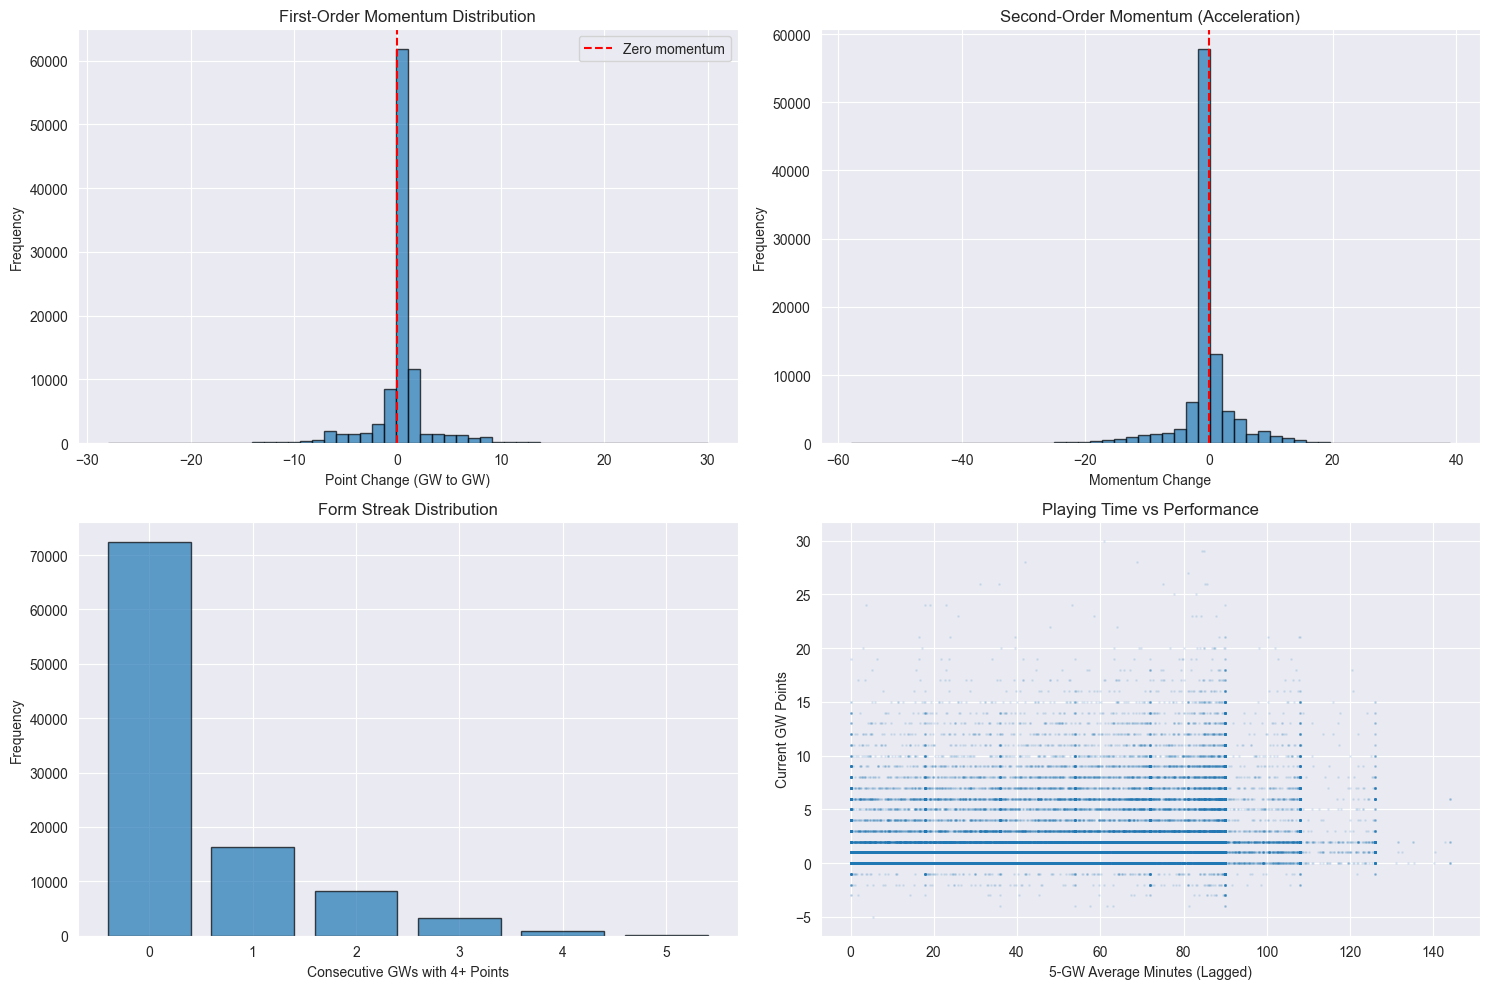

In [7]:
df = create_momentum_features(df)

# Visualize momentum patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Points momentum distribution
axes[0, 0].hist(df['points_momentum_1gw'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Point Change (GW to GW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('First-Order Momentum Distribution')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero momentum')
axes[0, 0].legend()

# Acceleration distribution
axes[0, 1].hist(df['points_acceleration'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Momentum Change')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Second-Order Momentum (Acceleration)')
axes[0, 1].axvline(0, color='red', linestyle='--')

# Streak analysis
streak_counts = df['streak_4pts'].value_counts().sort_index()
axes[1, 0].bar(streak_counts.index, streak_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Consecutive GWs with 4+ Points')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Form Streak Distribution')

# Minutes trend
axes[1, 1].scatter(df['minutes_trend_5gw'], df['total_points'], alpha=0.1, s=1)
axes[1, 1].set_xlabel('5-GW Average Minutes (Lagged)')
axes[1, 1].set_ylabel('Current GW Points')
axes[1, 1].set_title('Playing Time vs Performance')

plt.tight_layout()
plt.show()

## 3. Lag Features

Historical points at specific time lags:
$$L_k = points_{t-k}$$

These capture recent performance without aggregation.

In [9]:
def create_lag_features(df, lags=[1, 2, 3, 5, 10]):
    """
    Creates lagged target variable features.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sorted data
    lags : list
        Lag periods (in gameweeks)
        
    Returns
    -------
    pd.DataFrame
        DataFrame with lag features
    """
    df = df.copy()
    
    for lag in lags:
        df[f'points_lag_{lag}'] = df.groupby('element')['total_points'].shift(lag)
        df[f'minutes_lag_{lag}'] = df.groupby('element')['minutes'].shift(lag)
    
    print(f"Created {len(lags)*2} lag features")
    return df

In [11]:
df = create_lag_features(df, lags=[1, 2, 3, 5, 10])

# Validate lag features
print("\nLag Feature Validation:")
sample = df[df['element'] == df['element'].iloc[450]].head(20)
print(sample[['GW', 'total_points', 'points_lag_1', 'points_lag_2', 'points_lag_3']].to_string())


Created 10 lag features

Lag Feature Validation:
     GW  total_points  points_lag_1  points_lag_2  points_lag_3
428   1             0           NaN           NaN           NaN
429   2             1           0.0           NaN           NaN
430   3             1           1.0           0.0           NaN
431   4             9           1.0           1.0           0.0
432   5             2           9.0           1.0           1.0
433   6             7           2.0           9.0           1.0
434   7             2           7.0           2.0           9.0
435   8             9           2.0           7.0           2.0
436   9             6           9.0           2.0           7.0
437  10             2           6.0           9.0           2.0
438  11            -1           2.0           6.0           9.0
439  12             2          -1.0           2.0           6.0
440  13             1           2.0          -1.0           2.0
441  14             2           1.0           2.0      

## 4. Position-Specific Features

Different positions have different scoring patterns.



In [12]:
def create_position_features(df):
    """
    Creates position-normalized features.
    
    Idea: A midfielder scoring 8 points is different from
    a goalkeeper scoring 8 points. Normalize by position average.
    """
    df = df.copy()
    
    # Average points by position in each gameweek
    position_avg = df.groupby(['season', 'GW', 'position'])['total_points'].transform('mean')
    df['points_vs_position_avg'] = df['total_points'] - position_avg
    
    # Position rank percentile within each gameweek
    df['position_percentile'] = (
        df.groupby(['season', 'GW', 'position'])['total_points']
        .rank(pct=True)
    )
    
    print("Created position-specific features")
    return df

Created position-specific features


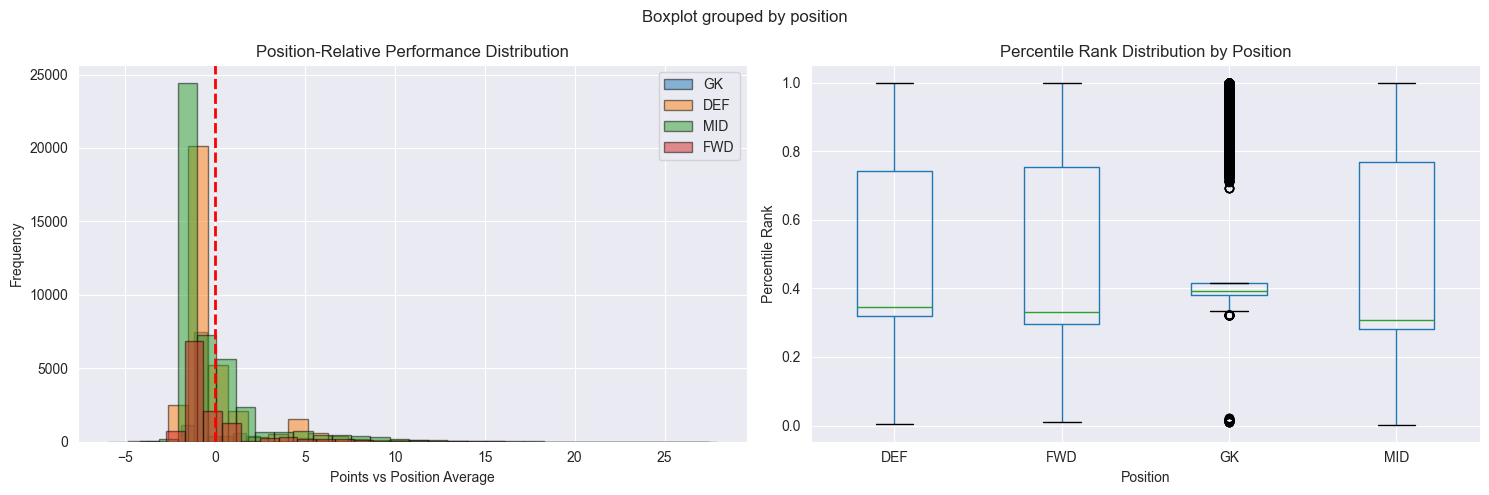

In [13]:
df = create_position_features(df)

# Visualize position-relative performance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for position in ['GK', 'DEF', 'MID', 'FWD']:
    pos_data = df[df['position'] == position]['points_vs_position_avg'].dropna()
    axes[0].hist(pos_data, bins=30, alpha=0.5, label=position, edgecolor='black')

axes[0].set_xlabel('Points vs Position Average')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Position-Relative Performance Distribution')
axes[0].legend()
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)

# Percentile distribution
df.boxplot(column='position_percentile', by='position', ax=axes[1])
axes[1].set_title('Percentile Rank Distribution by Position')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Percentile Rank')

plt.tight_layout()
plt.show()


## 5. Expected Goals Features (Handle Missing Data)

xG data only available from 2022-23 onward.

Strategy: Create separate features for xG-available periods.

In [ ]:
def create_xg_features(df):
    """
    Creates expected goals features with missing data handling.
    """
    df = df.copy()
    
    xg_cols = ['expected_goals', 'expected_assists', 'expected_goal_involvements']
    available_xg = [col for col in xg_cols if col in df.columns]
    
    if not available_xg:
        print("No expected goals columns found")
        return df
    
    # Rolling averages for xG metrics (where available)
    for col in available_xg:
        for window in [3, 5]:
            df[f'{col}_roll_mean_{window}'] = (
                df.groupby('element')[col]
                .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
            )
    
    # xG overperformance/underperformance
    if 'expected_goals' in df.columns:
        df['goals_vs_xg'] = df['goals_scored'] - df['expected_goals']
        df['goals_vs_xg_roll_3'] = (
            df.groupby('element')['goals_vs_xg']
            .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
        )
    
    print("Created expected goals features (available for seasons 2022-23+)")
    return df

In [15]:
df = create_xg_features(df)

# Check xG availability by season
print("\nExpected Goals Availability:")
if 'expected_goals' in df.columns:
    xg_summary = df.groupby('season')['expected_goals'].agg(['count', lambda x: x.notna().sum()])
    xg_summary.columns = ['Total_Rows', 'xG_Available']
    xg_summary['Coverage_%'] = (xg_summary['xG_Available'] / xg_summary['Total_Rows'] * 100).round(1)
    print(xg_summary)

Created expected goals features (available for seasons 2022-23+)

Expected Goals Availability:
         Total_Rows  xG_Available  Coverage_%
season                                       
2021-22           0             0         NaN
2022-23       24957         24957       100.0
2023-24       28742         28742       100.0
2024-25       14178         14178       100.0
2025-26       11090         11090       100.0


## 6. Feature Quality Assessment

In [ ]:
# Check for infinite or NaN values
feature_cols = [col for col in df.columns if any(x in col for x in 
                ['roll', 'lag', 'momentum', 'streak', 'trend', 'vs_', 'percentile'])]

print(f"\nTotal engineered features: {len(feature_cols)}")
print("\nFeature Quality Check:")

quality_check = pd.DataFrame({
    'Feature': feature_cols,
    'NaN_Count': [df[col].isna().sum() for col in feature_cols],
    'NaN_Pct': [df[col].isna().sum() / len(df) * 100 for col in feature_cols],
    'Inf_Count': [np.isinf(df[col]).sum() for col in feature_cols]
})

quality_check = quality_check.sort_values('NaN_Pct', ascending=False)
print(quality_check.head(20))


Total engineered features: 98

Feature Quality Check:
                                   Feature  NaN_Count    NaN_Pct  Inf_Count
93            expected_assists_roll_mean_5      24096  23.577992          0
91              expected_goals_roll_mean_5      24096  23.577992          0
97                      goals_vs_xg_roll_3      24096  23.577992          0
94  expected_goal_involvements_roll_mean_3      24096  23.577992          0
92            expected_assists_roll_mean_3      24096  23.577992          0
90              expected_goals_roll_mean_3      24096  23.577992          0
95  expected_goal_involvements_roll_mean_5      24096  23.577992          0
96                             goals_vs_xg      23230  22.730609          0
87                          minutes_lag_10       8531   8.347603          0
86                           points_lag_10       8531   8.347603          0
85                           minutes_lag_5       4305   4.212452          0
84                            poi

## 7. Feature Correlation Analysis

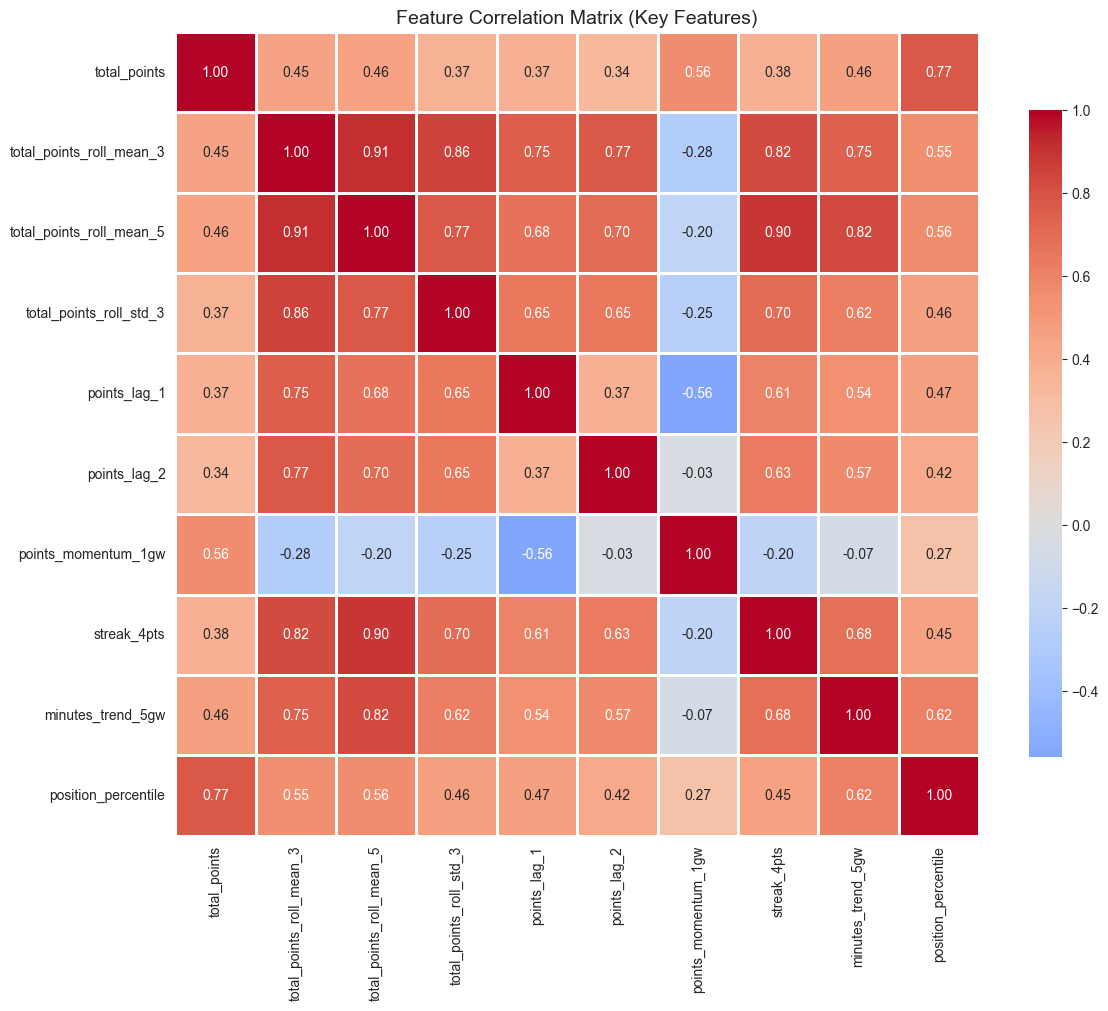


Highly Correlated Feature Pairs (|r| > 0.8):
total_points_roll_mean_3  total_points_roll_mean_5    0.913578
total_points_roll_mean_5  streak_4pts                 0.895934
total_points_roll_mean_3  total_points_roll_std_3     0.857456
total_points_roll_mean_5  minutes_trend_5gw           0.823728
total_points_roll_mean_3  streak_4pts                 0.819144
dtype: float64


In [17]:
# Select key features for correlation analysis
key_features = [
    'total_points',
    'total_points_roll_mean_3',
    'total_points_roll_mean_5',
    'total_points_roll_std_3',
    'points_lag_1',
    'points_lag_2',
    'points_momentum_1gw',
    'streak_4pts',
    'minutes_trend_5gw',
    'position_percentile'
]

# Filter to existing columns
key_features = [col for col in key_features if col in df.columns]

# Calculate correlation matrix
corr_matrix = df[key_features].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.2f')
plt.title('Feature Correlation Matrix (Key Features)', fontsize=14)
plt.tight_layout()
plt.show()

# High correlation pairs (potential multicollinearity)
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
upper_triangle = np.triu(np.ones_like(corr_matrix), k=1).astype(bool)
high_corr = corr_matrix.where(upper_triangle)
high_corr_pairs = high_corr.stack()
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.8].sort_values(ascending=False)
print(high_corr_pairs)

## 8. Filter Observations with Sufficient History

In [18]:
# Remove early gameweeks where rolling features are incomplete
print(f"\nBefore filtering: {len(df):,} observations")

# Keep only players with at least 10 GW history
df_filtered = df.groupby('element').filter(lambda x: len(x) >= 10)

# Additionally, remove first 10 GWs for each player
df_filtered = df_filtered.groupby('element').apply(lambda x: x.iloc[10:]).reset_index(drop=True)

print(f"After filtering: {len(df_filtered):,} observations")
print(f"Removed: {len(df) - len(df_filtered):,} observations ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")



Before filtering: 102,197 observations
After filtering: 93,666 observations
Removed: 8,531 observations (8.3%)


## 9. Save Engineered Features


In [ ]:
# Save to processed directory
output_file = PROCESSED_DIR / "fpl_features_engineered.csv"
df_filtered.to_csv(output_file, index=False)

print("\nFeature engineering complete!")
print(f"Saved to: {output_file}")
print(f"Final shape: {df_filtered.shape}")

# Feature summary
print("\nFeature Categories:")
print(f"  - Rolling stats: {len([c for c in df_filtered.columns if 'roll' in c])}")
print(f"  - Momentum: {len([c for c in df_filtered.columns if 'momentum' in c or 'streak' in c])}")
print(f"  - Lags: {len([c for c in df_filtered.columns if 'lag' in c])}")
print(f"  - Position-specific: {len([c for c in df_filtered.columns if 'position' in c or 'vs_' in c])}")
print(f"  - Expected goals: {len([c for c in df_filtered.columns if 'expected' in c and 'roll' in c])}")


Feature engineering complete!
Saved to: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\data\processed\fpl_features_engineered.csv
Final shape: (93666, 151)

Feature Categories:
  - Rolling stats: 79
  - Momentum: 5
  - Lags: 10
  - Position-specific: 5
  - Expected goals: 6
